**Table of contents**<a id='toc0_'></a>    
- [Star Sky Simulation](#toc1_)    
  - [I part: The field](#toc1_1_)    
    - [I.1 Packages and Parameters](#toc1_1_1_)    
    - [I.2 Generating the sample](#toc1_1_2_)    
    - [I.3 Some useful stuff](#toc1_1_3_)    
    - [I.4 Generating the source field](#toc1_1_4_)    
    - [I.5 Atmospheric Seeing](#toc1_1_5_)    
    - [I.6 Background and Detector Noise](#toc1_1_6_)    
  - [II part: The detection](#toc1_2_)    
    - [II.1 Dark elaboration](#toc1_2_1_)    
    - [II.2 Searching and extracting](#toc1_2_2_)    
      - [II.2.1 Accuracy and precision](#toc1_2_2_1_)    
  - [III part: Image recover](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***

# <a id='toc1_'></a>[Star Sky Simulation](#toc0_)

## <a id='toc1_1_'></a>[I part: The field](#toc0_)

### <a id='toc1_1_1_'></a>[I.1 Packages and Parameters](#toc0_)

After importing the packages will be used later, I begin by defining of the parameters of the system, such as the dimension of the field `N`, the number of stars `M`, the power law for IMF and mass-luminosity relation, `alpha` and `beta` respectively.

The minimum `m_min` and the maximum `m_max` values for the sample masses are set here.

In [42]:

##* packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import os

# getting th current directory
pwd = os.getcwd()

# dimension of the field matrix
N = int(1e2+1)
# number of stars
M = int(1e2)

# setting parameters of power laws
alpha = 2   # for IMF
beta  = 3   # for M-L relation
# minimum and maximum masses in solar mass units
m_min = 0.1; m_max = 20
# Initial Mass Function
IMF = lambda m : m**(-alpha)

# calculating IMF for the extreme masses
IMF_min = IMF(0.1); IMF_max = IMF(20) 

print(f'IMF for smallest and biggest stars:\nM\t\tIMF\n0.1 Msun\t{IMF_min}\n20  Msun\t{IMF_max}')


IMF for smallest and biggest stars:
M		IMF
0.1 Msun	99.99999999999999
20  Msun	0.0025


### <a id='toc1_1_2_'></a>[I.2 Generating the sample](#toc0_)

In order to populate the field from the IMF, the `generate_mass_array` is here implemented and the corresponding luminosity array is evaluated.

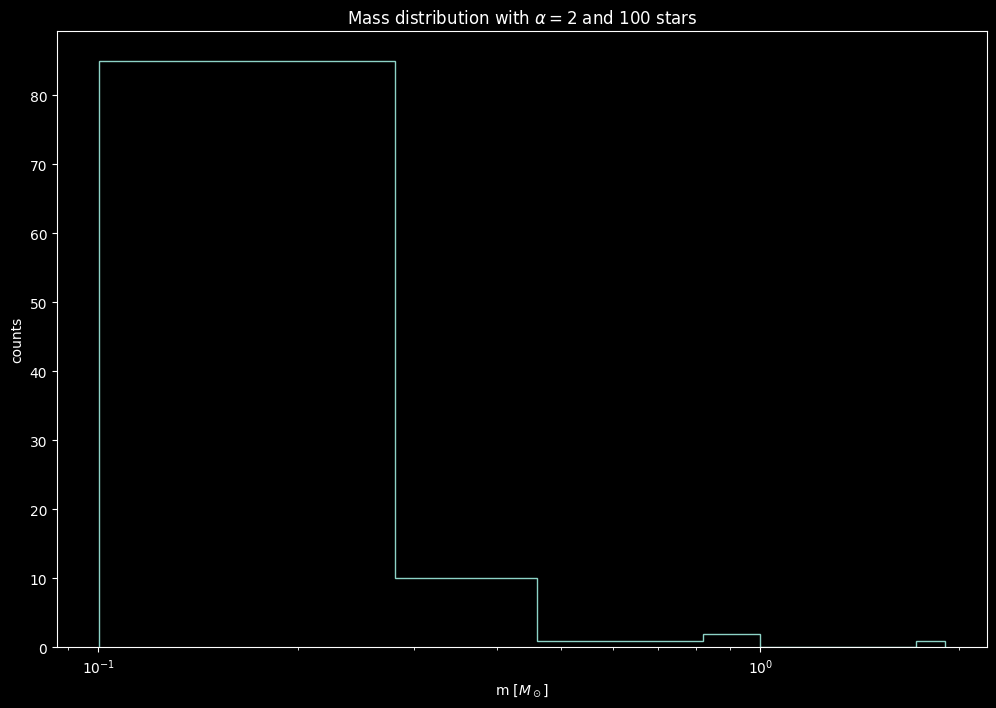

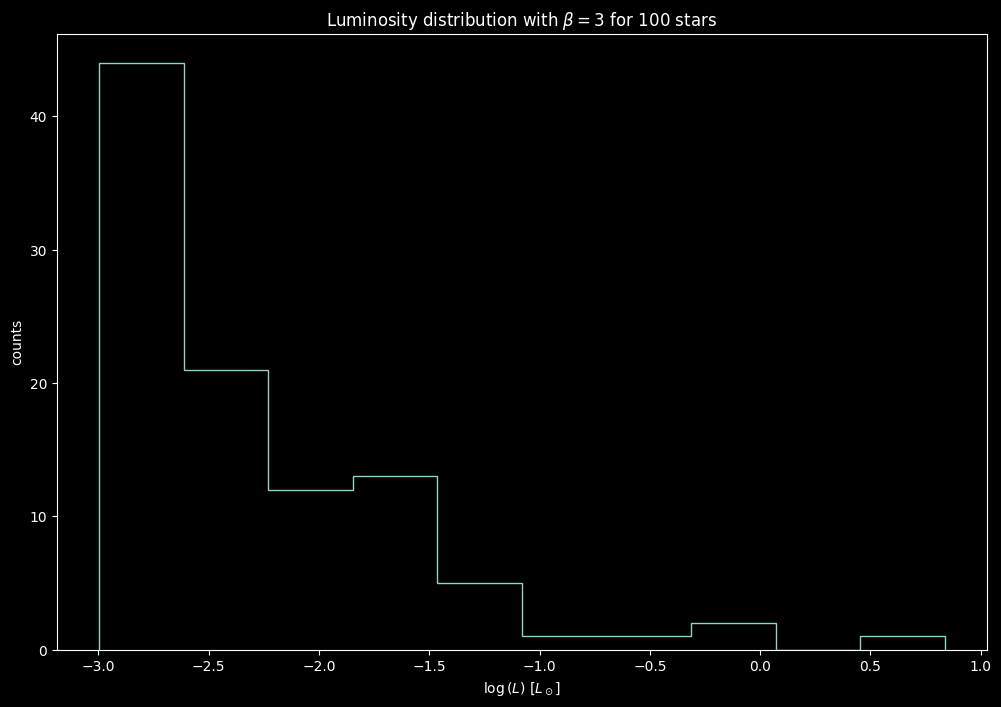

In [43]:

##* 
def generate_mass_array(m_min: float = 0.1, m_max: float = 20, alpha: float = 2,  sdim: int = M) -> np.ndarray:
    """Generating masses array from the IMF distribution
    The function takes the minimum and the maximum masses, the IMF 
    and generates a `sdim`-dimensional array of masses distributed like 
    IMF.

    The chosen method is a straightforward Monte Carlo: 
    generating uniformly random values for IMF and 
    calculating the corresponding mass.

    :param m_min: the minimum mass, defaults to 0.1 Msun
    :type m_min: float
    :param m_max: the maximum mass, defaults to 20 Msun
    :type imf_max: float
    :param alpha: the exponent of the power law, defaults to 2
    :type alpha: float
    :param sdim: number of stars, defaults to `M`
    :type sdim: int, optional

    :return: `sdim`-dimensional array of masses distributed like IMF
    :rtype: np.ndarray
    """
    # intial mass function
    IMF = lambda m : m**(-alpha)
    # evaluating IMF for the extremes
    imf_min = IMF(m_min)
    imf_max = IMF(m_max) 
    # initializing random seed
    np.random.seed()
    # generating the sample 
    return (np.random.rand(sdim)*(imf_min-imf_max)+imf_max)**(-1/alpha)

# M-dim array of masses in solar mass unit
m = generate_mass_array()

# M-dim array of luminosities in solar luminosity unit
L = m**beta


## Plot data for masses
plt.figure(1, figsize=(12,8))
plt.title(f'Mass distribution with $\\alpha = {alpha}$ and {M} stars')
plt.hist(m, histtype='step')
plt.xscale('log')
plt.xlabel('m [$M_\odot$]')
plt.ylabel('counts')


## Plot data for corrisponfding luminosities
# plot the logarithm of L
plt.figure(2, figsize=(12,8))
plt.title(f'Luminosity distribution with $\\beta = {beta}$ for {M} stars')
plt.hist(np.log10(L),histtype='step')
plt.xlabel('$\log{(L)}$ [$L_\odot$]')
plt.ylabel('counts')


plt.show()



### <a id='toc1_1_3_'></a>[I.3 Some useful stuff](#toc0_)


I define a new class, named `star`, in order to store each parameter of generating stars in the following, and write a function `field_image()` just to display the field.

In [44]:

##* 
class star():
    """Star object class.
    This class will be used only to store the 
    parameters of star object.

    :param mass: star mass
    :type mass: float
    :param lum: star luminosity
    :type lum: float
    :param pos: star coordinates (x,y)
    :type pos: tuple[np.ndarray, np.ndarray]
    """
    def __init__(self, mass: float, lum: float, pos: tuple[np.ndarray, np.ndarray]):
        self.m   = mass        # star mass value
        self.lum = lum        # star luminosity value
        self.pos = pos        # star coordinates


##*   
def field_image(fig, image, F: np.ndarray, v: int = 0, sct: tuple = (0,None), norm: str = 'log') -> None:
    """Function to display the field.
    It is possible to display only a section of the field 
    through the parameter `sct` 

    :param fig: figure variable
    :type fig: Any
    :param image: subplot variable
    :type image: Any
    :param F: field matrix
    :type F: np.ndarray
    :param v: set the color of the image: 1 for artificial color, 0 for grayscale, -1 for inverse grayscale. Defaults to 0.
    :type v: int, optional
    :param sct: selected square section of the field, defaults to (0,None)
    :type sct: tuple, optional
    """ 
    # extracting the edges of image
    a,b = sct
    # setting the color map from `v` param
    if v == 0: color = 'gray'
    elif v == 1: color = 'viridis' 
    else: color = 'gray_r' 
    # generating the image
    pic = image.imshow(F[a:b,a:b], cmap=color, norm=norm)
    # generating the colorbar
    fig.colorbar(pic, ax=image, cmap=color, norm=norm, location='bottom')
  

### <a id='toc1_1_4_'></a>[I.4 Generating the source field](#toc0_)

In this section the field without any kind of noise and seeing effect is generated. The aim is to get a `(N,N)` dimensional field with `M` stars, distributed like the `IMF` in mass and uniformly in positions. The whole luminosity of each star is in a single pixel, so one can treat every source like a _delta-function_ signal. 

After that functions to locate randomly stars and to update the field were implemented, I created another one to initialize the process.

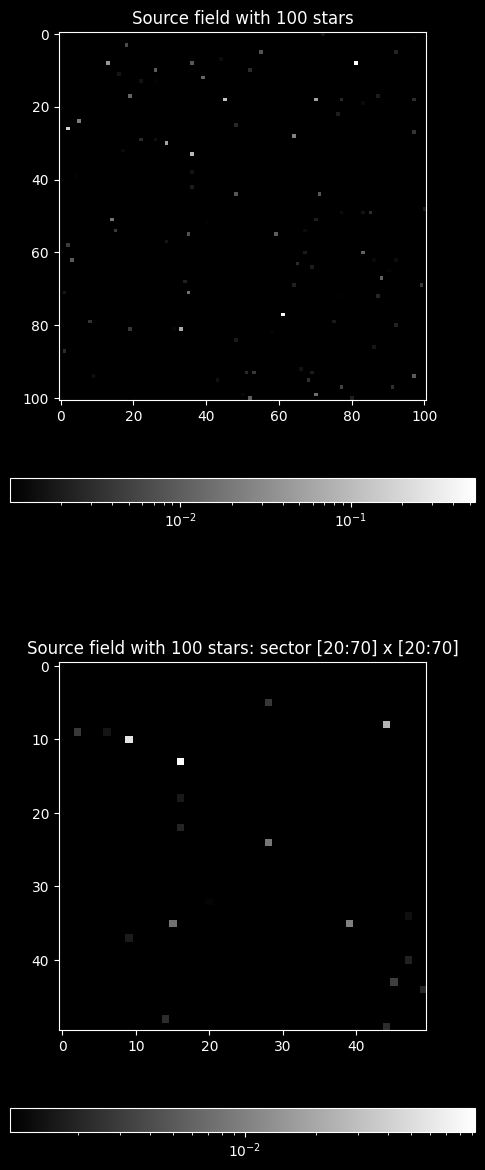

In [45]:

##* 
def star_location(sdim: int = M, dim: int = N) -> tuple[np.ndarray,np.ndarray]:
    """Function to locate the stars.
    It generates a list with all possible positions in the
    field matrix and draws `sdim` of those. Then it collects
    the drawn coordinates in two different arrays
    (x and y respectively).

    The parameter `replace` in `np.random.choice()` set to
    `False` forces each star has an unique position;
    in other words, no superimposition effect happens. 

    :param sdim: number of stars, defaults to `M`
    :type sdim: int, optional
    :param dim: size of the field, defaults to `N`
    :type dim: int, optional

    :return: tuple of star coordinates arrays `X` and `Y`
    :rtype: tuple

    .. todo:: 
        - #! Check the `replace` condition in `np.random.choice()`
          #? Is it a good choice?
    """
    # list with all possible positions in the field
    grid = [(i,j) for i in range(dim) for j in range(dim)]
    # drawing positions from grid for stars
    ind = np.random.choice(len(grid), size=sdim, replace=False)
    # making arrays of coordinates
    X = np.array([grid[i][0] for i in ind])
    Y = np.array([grid[i][1] for i in ind])
    return (X, Y)    

##* 
def update_field(F: np.ndarray, pos: tuple[np.ndarray, np.ndarray], lum: np.ndarray) -> np.ndarray:
    """Function to update the field.
    It adds the generated stars to the field.

    :param F: field matrix
    :type F: np.ndarray
    :param pos: star coordinates
    :type pos: tuple[np.ndarray, np.ndarray]
    :param lum: luminosities array
    :type lum: np.ndarray

    :return: updated field matrix
    :rtype: np.ndarray
    """
    # uppdating the field
    F[pos] += lum
    return F


def check_field(field: np.ndarray) -> np.ndarray:
    """Check the presence of negative values.
    The function finds possible negative values
    and substitutes them with 0.0

    :param field: field matrix
    :type field: ndarray

    :return: checked field matrix
    :rtype: ndarray
    """
    return np.where(field < 0, 0.0, field)


##*
def initialize(dim: int = N, sdim: int = M, masses: tuple[float, float] = (0.1, 20), alpha: float = 2, beta: float = 3) -> tuple[np.ndarray,star]:
    """Initialization function for the generation of the "perfect" sky
    It generates the stars and updates the field without any seeing 
    or noise effect.

    :param dim: size of the field, defaults to N
    :type dim: int, optional
    :param sdim: number of stars, defaults to M
    :type sdim: int, optional
    :param masses: the extremes of masses range, defaults to (0.1, 20)
    :type masses: tuple[float, float], optional
    :param alpha: exponent of IMF, defaults to 2
    :type alpha: float, optional
    :param beta: exponent of M-L relation, defaults to 3
    :type beta: float, optional

    :return: the field matrix F and :class: `star` object with all the stars informations
    :rtype: tuple
    """
    # generating an empty field (dim,dim) matrix
    F = np.zeros((dim,dim))
    m_inf, m_sup = masses
    # generating masses
    m = generate_mass_array(m_inf, m_sup, alpha=alpha, sdim=sdim)
    # evaluating corrisponding luminosities
    L = m**beta
    # locating the stars
    star_pos = star_location(sdim=sdim, dim=dim)
    # updating the field matrix
    F = check_field(update_field(F,star_pos,L))
    # saving stars infos
    S = star(m,L,star_pos)
    return F, S

# generation of the field and the stars
F, S = initialize()

## Plot
# variables to take a sector [inf:sup] x [inf:sup] of the field
inf = int(0.2*N)
sup = int(0.7*N)

fig, axs = plt.subplots(2, 1, figsize=(6,15))

#  0 : positive image
# -1 : negative image
v = 0

img_field, img_zoom = axs

field_image(fig, img_field,F,v)
#img_field.imshow(1-F)
img_field.set_title(f'Source field with {M} stars')
field_image(fig, img_zoom,F,v,[inf,sup])
#img_zoom.imshow(1-F[inf:sup,inf:sup,:])
img_zoom.set_title(f'Source field with {M} stars: sector [{inf}:{sup}] x [{inf}:{sup}]')

plt.show()

### <a id='toc1_1_5_'></a>[I.5 Atmospheric Seeing](#toc0_)

The atmospheric seeing effect is considered in this exercise as the convolution of the previous _"perfect"_ field (_delta sources_) with a gaussian function. The variance of the latter is arbitrary; I chose a `sigma` of 0.5.

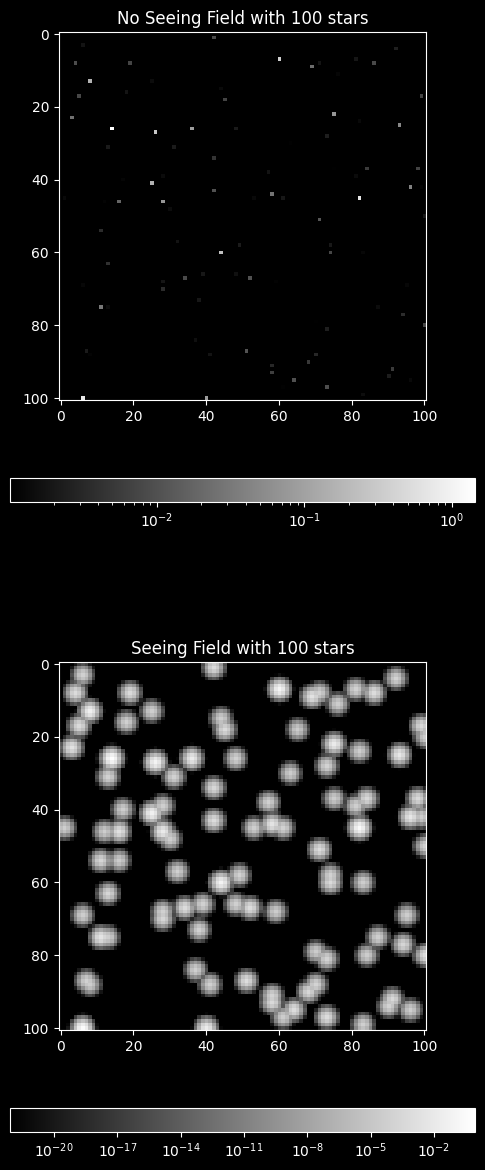

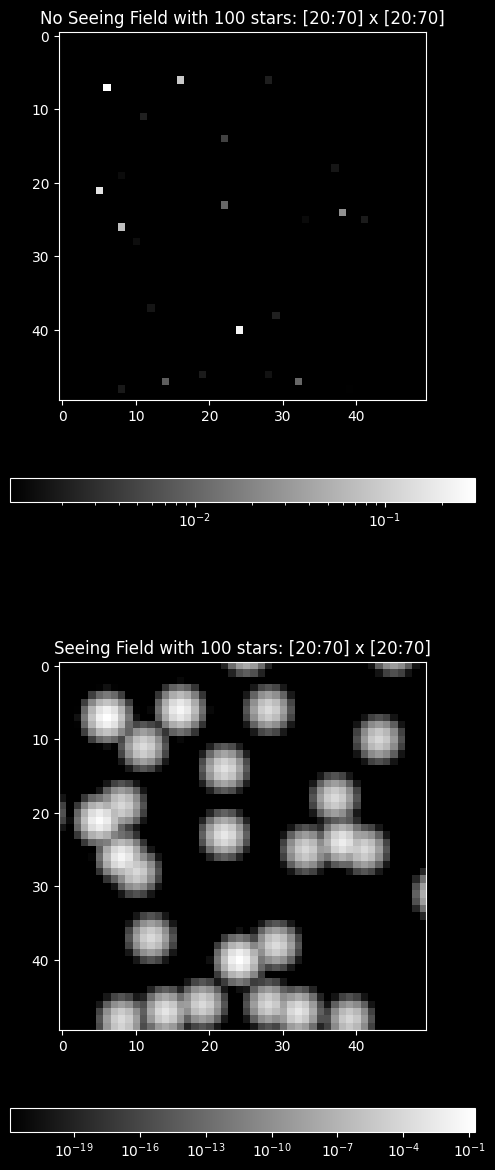

In [46]:
# SIXTH CELL
##* 
def gaussian(sigma: float = 0.5, dim: int = N) -> np.ndarray:
    """Gaussian matrix generator
    It generates a gaussian (`dim`,`dim`) matrix, centered in 
    (`dim//2`,`dim//2`)

    :param sigma: the root of the variance, defaults to 0.5
    :type sigma: float, optional
    :param dim: size of the field, defaults to N
    :type dim: int, optional
    
    :return: gaussian (dim,dim) matrix
    :rtype: np.ndarray
    """
    # generating arrays of all positions
    x = np.arange(dim, dtype=int)
    y = np.arange(dim, dtype=int)
    # shifting to center of the field
    x -= dim // 2  
    y -= dim // 2
    # gaussian function expression
    G = lambda r : np.exp(-(r/sigma)**2/2)
    # computing the outer product
    kernel = np.outer(G(x),G(y))
    return kernel/kernel.sum()


##* 
def atm_seeing(field: np.ndarray, sigma: float = 0.5) -> np.ndarray:
    """Atmosferic seeing function
    It convolves the field with tha Gaussian to
    make the atmosferic seeing

    :param field: field matrix
    :type field: np.ndarray
    :param sigma: the root of variance of Gaussian, defaults to 0.5
    :type sigma: float, optional
    
    :return: field matrix with seeing
    :rtype: np.ndarray
    """
    # dim of the field
    n = len(field)
    # coping the field in order to preserve it
    see_field = np.copy(field)
    # convolution with gaussian seeing
    see_field = fftconvolve(see_field, gaussian(sigma=sigma, dim=n), mode='same')
    # checking the field and returning it
    return check_field(see_field)

# generation of the field and the stars
F, S = initialize()

## Plot variables
fig1, (img_field, img_field_seeing) = plt.subplots(2,1,figsize=(6,15))
fig2, (img_zoom, img_zoom_seeing)   = plt.subplots(2,1,figsize=(6,15))

#  0 : positive image
# -1 : negative image
v = 0

field_image(fig1, img_field,F,v)
img_field.set_title(f'No Seeing Field with {M} stars')
field_image(fig1, img_zoom,F,v,[inf,sup])
img_zoom.set_title(f'No Seeing Field with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')


# generation of the seeing image
F_s = atm_seeing(F)


field_image(fig2, img_field_seeing,F_s,v)
#img_field_seeing.imshow(1-F_s)
img_field_seeing.set_title(f'Seeing Field with {M} stars')
field_image(fig2, img_zoom_seeing,F_s,v,[inf,sup])
#img_zoom_seeing.imshow(1-F_s[inf:sup,inf:sup,:])
img_zoom_seeing.set_title(f'Seeing Field with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')

# path for images directory
picdir = os.path.join(pwd,'Pictures')

# par to save figures
#   1   save
#   0   not
sv = 0

if sv == 1:
    fig1.savefig(os.path.join(picdir,'field.png'))
    fig2.savefig(os.path.join(picdir,'zoom.png'))

plt.show()
    
    

### <a id='toc1_1_6_'></a>[I.6 Background and Detector Noise](#toc0_)

Due to the fact that both kinds of noise are uniform ones, only one function for the noise computation was implemented. 

The difference is just the value of the maximum: 
  - background: $0.2 \%$ of the luminosity of a solar mass star
  - detector: $3 \cdot 10^{-4}$ in solar luminosity units

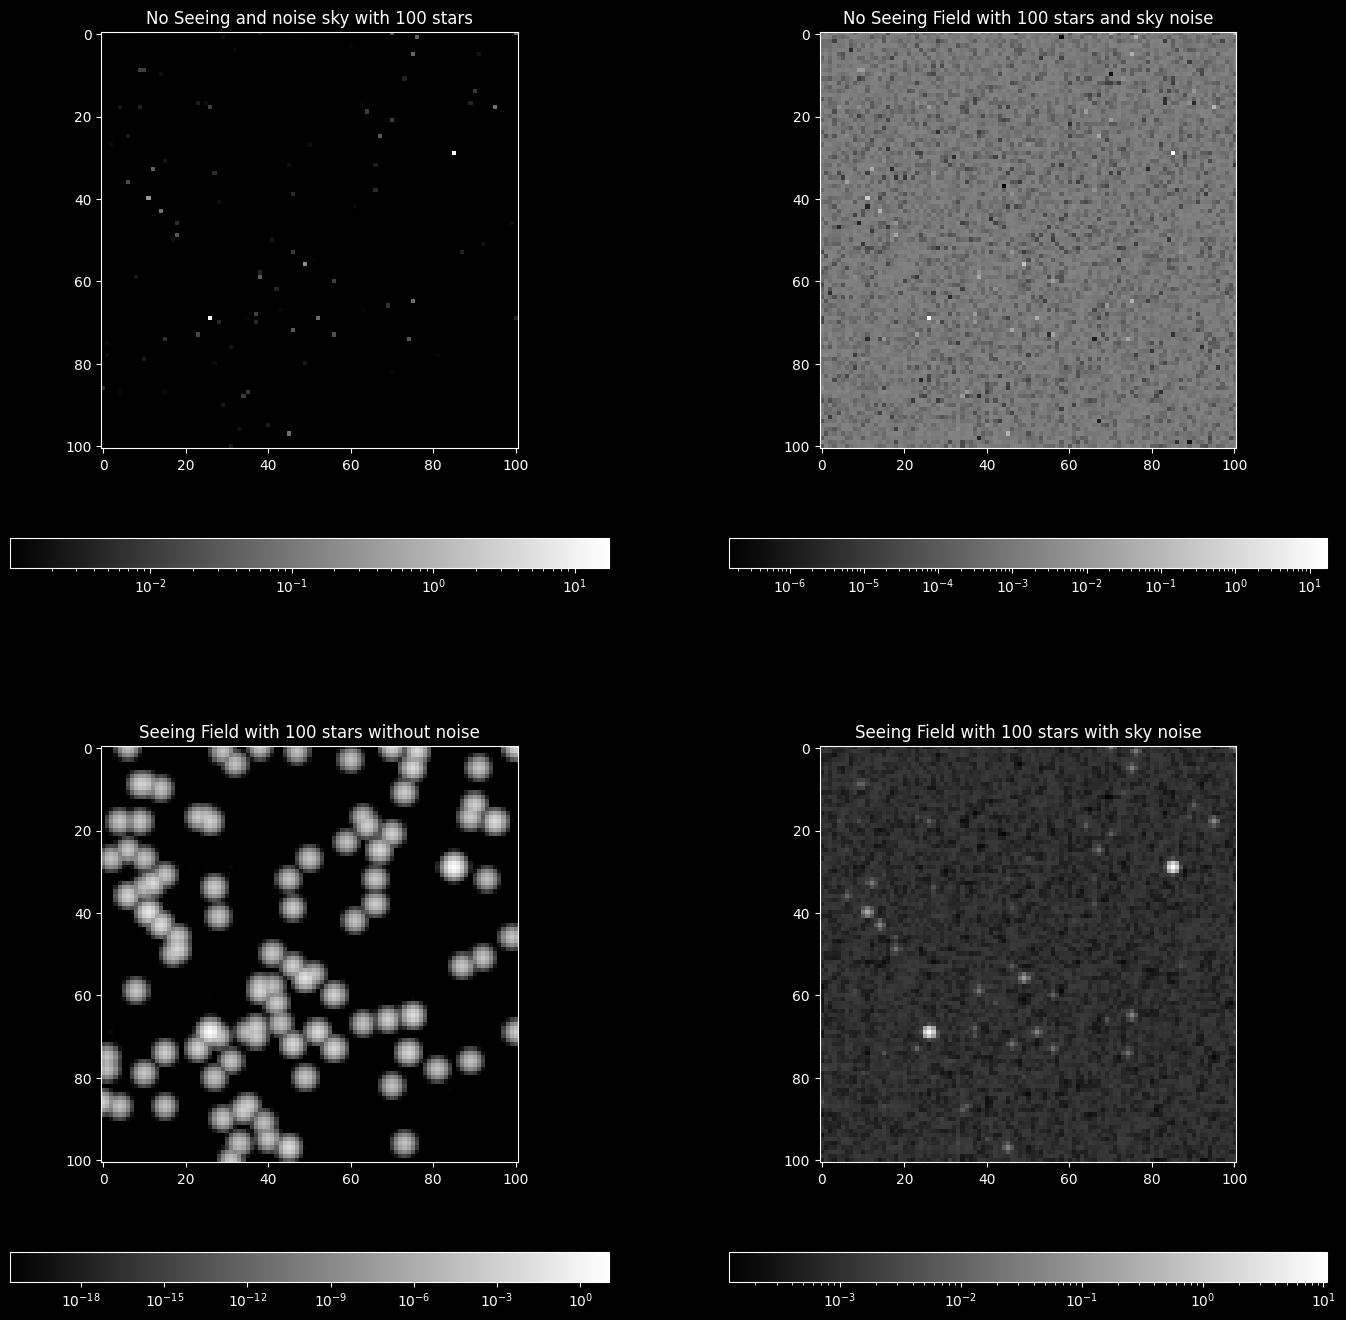

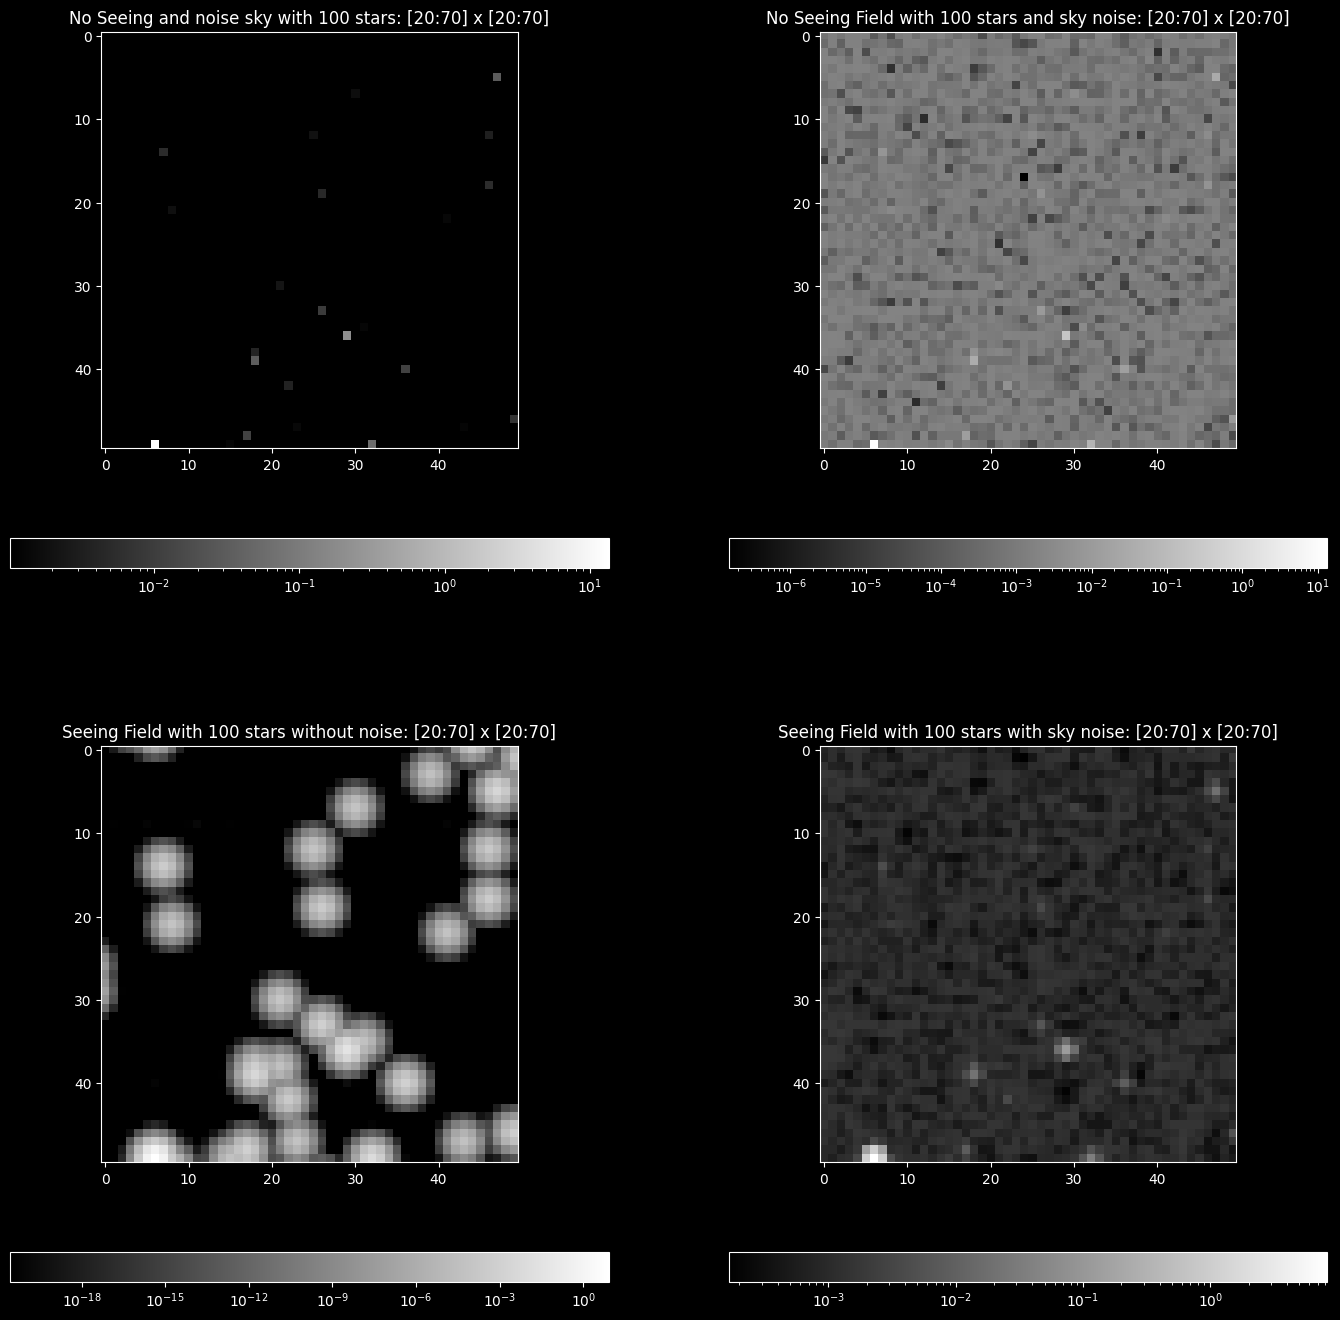

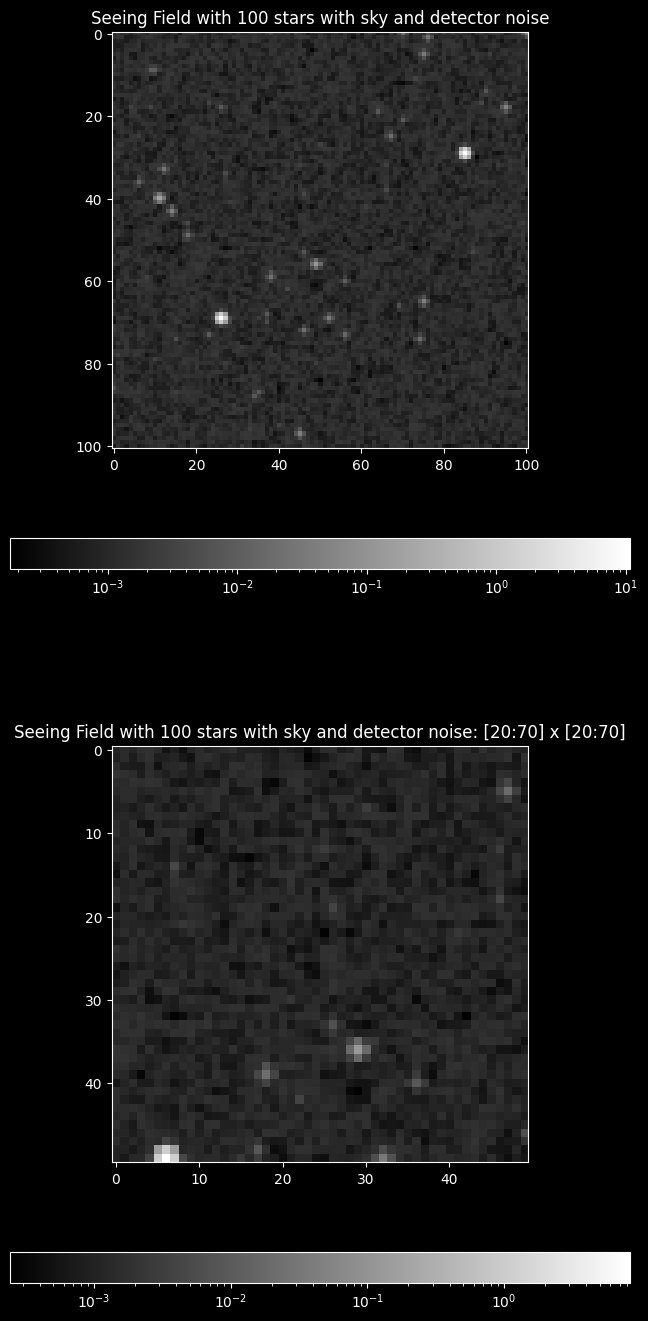

In [47]:


##* 
def noise(n: float, dim: int = N) -> np.ndarray:
    """Noise generator
    It generates a (dim,dim) matrix of noise, using
    an arbitrary maximum intensity n.

    :param n: max intensity of noise
    :type n: float
    :param dim: size of the field, defaults to N
    :type dim: int, optional

    :return: noise matrix
    :rtype: np.ndarray
    """
    # initializing the seed
    np.random.seed()
    # (`dim`,`dim`) matrix with random numbers 
    N0 = np.random.random((dim, dim))*n
    # checking the field
    return check_field(N0)

# background noise, set to 0.2 % of solar luminosity
bg_noise = 0.2/1e2

# detector noise
det_noise = 3e-4

# generation of the field and the stars
F, S = initialize()

# adding background noise
F_n = F + noise(bg_noise)


## Plot
fig1, ((img_field, img_field_noise),(img_field_seeing,img_field_snoise)) = plt.subplots(2,2,figsize=(17,17))
fig2, ((img_zoom, img_zoom_noise)  ,(img_zoom_seeing,img_zoom_snoise))   = plt.subplots(2,2,figsize=(17,17))
fig3, (img_field_tot, img_zoom_tot) = plt.subplots(2,1,figsize=(8,17))

#  0 : positive image
# -1 : negative image
v = 0


field_image(fig1, img_field,F,v)
img_field.title.set_text(f'No Seeing and noise sky with {M} stars')
field_image(fig2, img_zoom,F,v,[inf,sup])
img_zoom.title.set_text(f'No Seeing and noise sky with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')

field_image(fig1, img_field_noise,F_n,v)
img_field_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise')
field_image(fig2, img_zoom_noise,F_n,v,[inf,sup])
img_zoom_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise: [{inf}:{sup}] x [{inf}:{sup}]')



# generating atmosferic seeing image without sky noise
F_s = atm_seeing(F)



field_image(fig1, img_field_seeing,F_s,v)
img_field_seeing.title.set_text(f'Seeing Field with {M} stars without noise')
field_image(fig2, img_zoom_seeing,F_s,v,[inf,sup])
img_zoom_seeing.title.set_text(f'Seeing Field with {M} stars without noise: [{inf}:{sup}] x [{inf}:{sup}]')



# generating atmosferic seeing image with sky noise
F_sn = atm_seeing(F_n)



field_image(fig1, img_field_snoise,F_sn,v)
img_field_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise')
field_image(fig2, img_zoom_snoise,F_sn,v,[inf,sup])
img_zoom_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise: [{inf}:{sup}] x [{inf}:{sup}]')


# adding detector noise
F_sn += noise(det_noise)


field_image(fig3, img_field_tot,F_sn,v)
img_field_tot.title.set_text(f'Seeing Field with {M} stars with sky and detector noise')
field_image(fig3, img_zoom_tot,F_sn,v,[inf,sup])
img_zoom_tot.title.set_text(f'Seeing Field with {M} stars with sky and detector noise: [{inf}:{sup}] x [{inf}:{sup}]')

if sv == 1:
    fig1.savefig(os.path.join(picdir,'field_noise.png'))
    fig2.savefig(os.path.join(picdir,'zoom_noise.png'))
    fig3.savefig(os.path.join(picdir,'image.png'))

plt.show()


## <a id='toc1_2_'></a>[II part: The detection](#toc0_)

In this part the script focuses on searching and detecting objects in a field, generated as before. The aim is to recover the IMF, removing the seeing effect. 

### <a id='toc1_2_1_'></a>[II.1 Dark elaboration](#toc0_)

First I implemented a function to estimate the value of the detector noise through the computing of a set of darks.

max value =	0.0002927069450888329
mean value =	0.0001495808280877042


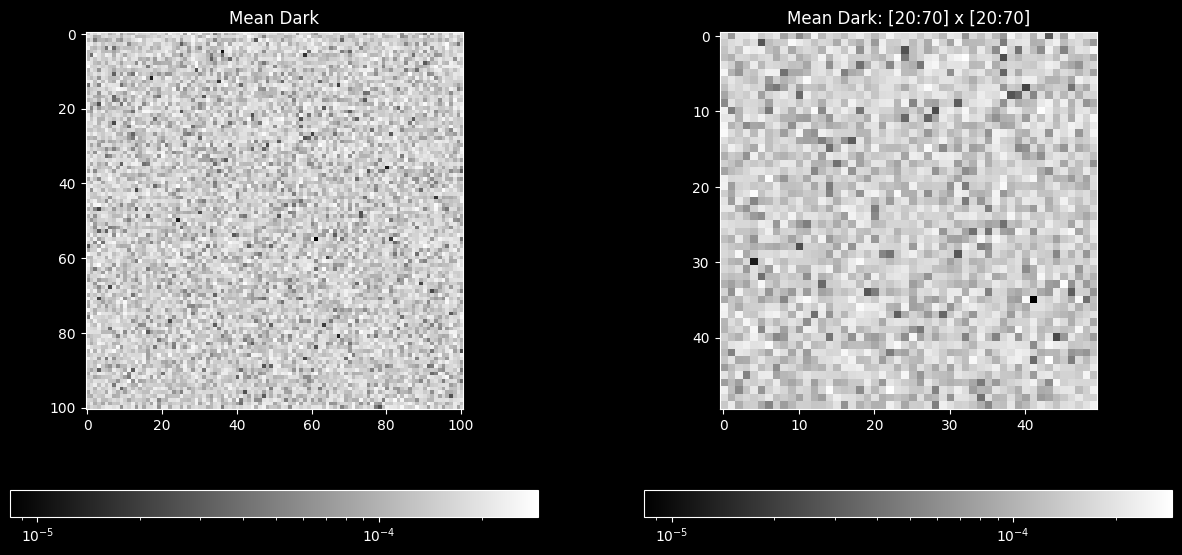

In [48]:

##*
def dark_elaboration(n_value: float = 3e-4, iteration: int = 3, dim: int = N) -> np.ndarray:
    """The function computes a number (`iteration`) of darks
    and averages them in order to get a mean estimation 
    of the detector noise

    :param n_value: detector noise, defaults to 3e-4
    :type n_value: float, optional
    :param iteration: number of darks to compute, defaults to 3
    :type iteration: int, optional

    :return: mean dark
    :rtype: np.ndarray
    """
    # generating the first dark
    dark = noise(n_value, dim=dim)
    # making the loop
    for i in range(iteration-1):
        dark += noise(n_value, dim=dim)
    # averaging
    dark /= iteration
    return dark

# doing the dark routine
dark = dark_elaboration()

print(f'max value =\t{dark[np.unravel_index(np.argmax(dark),dark.shape)]}')
print(f'mean value =\t{dark.sum()/(len(dark)**2)}')

## Plot
fig1, (dark_img, dark_zoom) = plt.subplots(1,2,figsize=(15,7))

#  0 : positive image
# -1 : negative image
v = 0

dark_img.set_title('Mean Dark')
field_image(fig1, dark_img,dark,v)
dark_zoom.set_title(f'Mean Dark: [{inf}:{sup}] x [{inf}:{sup}]')
field_image(fig1, dark_zoom,dark,v,[inf,sup])

plt.show()    

### <a id='toc1_2_2_'></a>[II.2 Searching and extracting](#toc0_)

The detecting algorithm is the main part of the exercise. My implementation is quite simple: 

  1. **Making a copy of the field**
   
  2. **Finding the most luminous pixel**

  3. **Studying the size of the object**

      Two functions are used for this step: `grad_check()` and `size_est()`. The former looks around the selected pixel in four different directions (_x_, _y_ and diagonal ones) to detect possible nearby objects, studying the trend of the luminosity from the center outward. The latter sets the size of the object in the frame get from `grad_check()` depending on one of two parameters: either the maximum number of pixels per image (`size`) or the minimum ratio between the external and central values (`thr`). The definition of these constrains is inherent in the definition of what one considers _"an object"_, so their values are purely arbitrary. I chose 2 magnitudes for the ratio and 3 pixels for the half width of an object.    

  4. **Removing the object from the field**

      The detected object is removed from the copy of the field and stored in an array (`a_extraction`).

  5. **Starting again from step 1** until the _signal-to-noise_ ratio (SNR) reaches a threshold value (set to 2) 
   
      To compute the SNR, an estimation of noise value is necessary. In order to do that, the script takes the maximum among 4 values, estimated by averaging the luminosity of a chosen number of random points in the field (`evaluate_noise()`). Then the maximum between the result and the detector noise (get from dark) is computed. This _mean noise estimation routine_ (MNER) could be affected by the light of the most brilliant stars (which leads to overestimate the noise), hence for the first step the `evaluate_noise()` function returns the average of the four values that is compared with the $10\%$ of the highest luminosity later. This initial noise estimation (MNER-0) leads to a SNR (named SNR0) which is used for the condition to run the MNER. In other words, the MNER is used only if the condition on SNR0 is satisfied. This ensures that when script runs MNER high luminosity stars was removed.     


![detect](/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/notebook/detecting_routine.png)



#### <a id='toc1_2_2_1_'></a>[II.2.1 Accuracy and precision](#toc0_)

I wrote a script (named `test_thr.py`) in order to estimate the efficiency of the algorithm. I proceeded in two different ways: setting the luminosity of stars by my own and generating them from IMF.

  1. In the first case I chose a set of luminosities: $\bigl [n\cdot 10^{-1},\: n + 2\cdot 10^{-3},\: n\cdot 5,\: n\cdot 10,\: n\cdot 100 \bigr ]$ (where $n$ is the background noise). This method allows one to predict exactly the limit of how many objects the program is able to find. I defined two quantities to evaluate the efficiency: _precision_, that is the fraction of extracted objects over expected ones, and _accuracy_, that is the fraction of how many detected objects are really generated stars. 

        $$ prec \equiv \frac{\text{extracted}}{\text{expected}} \qquad acc \equiv \frac{\text{true objs}}{\text{extracted}} $$

        According to the definitions, the best condition is $prec = 1$ and $acc = 1$.

        ![trend1](/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/tests/test_thr.png)

        As shown in the plot, the trends are opposite. There is nothing strange in that. Precision is high for low number of stars because of the presence of false detected objects ($\text{extracted} = \text{expected} + \text{fake} > \text{expected}$). Vice versa, as the number of stars grows the fraction of wrong detections over the total sample decreases. The lower value of precision is related with the fact that high luminosity stars cover up light from lower ones and this effect leads to detect less objects than how much is expected.

  2. For the IMF the result is similar, but in this case the number of expected objects is defined as how many stars have a luminosity greater than $n$; so it is possible to have $prec \geq 1$ and $acc = 1$.
   
        ![trend2](/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/tests/test_thr-IMF.png)

In [49]:

##*
def grad_check(field: np.ndarray, index: tuple[int,int], size: int = 3) -> tuple[np.ndarray,np.ndarray]:
    """Function explores the neighbourhood of a selected object and gives its size.
    It studies the gradient around the obj in the four cardinal directions and the diagonal ones.
    It takes in account also the presence of the edges of the field.
    If no other obj is found in a whichever direction, that one is stored and returned.

    :param field: the field matrix
    :type field: np.ndarray
    :param index: the obj coordinates
    :type index: tuple[int,int]
    :param size: the upper limit for the size of the obj, defaults to 3
    :type size: int, optional
    
    :return: a tuple with:
             * a_size : array with the size of the obj in each directions, like [x_up, x_down, y_up, y_down]
             * ind_neg : indeces in `a_size` for free directions or in case of no free direction np.array([-1])
    :rtype: tuple[np.ndarray,np.ndarray]
    """    
    # field size
    dim = len(field)
    # object coordinates
    x, y = index
    # treatment for edges; f stays for forward, b for backward
    # maximum dimension of the object (the frame)
    xsize_f0, xsize_b0 = min(size, dim-1-x), min(size, x)
    ysize_f0, ysize_b0 = min(size, dim-1-y), min(size, y)
    # saving them in an array
    # the negative sign is used to take trace of free direction
    # starting from isolate object case
    a_size0 = np.array([xsize_f0,xsize_b0,ysize_f0,ysize_b0], dtype=int) * -1
    # limits of the frame to compute the gradient
    xlim_f, ylim_f = min(size, dim-2-x), min(size, dim-2-y)
    xlim_b, ylim_b = min(size, x+1), min(size, y+1)
    # creating an array to store the size of the object in differt directions
    a_size = np.copy(a_size0)
    # moving in the eight directions
    for i_f, i_b, j_f, j_b in zip(range(xlim_f), range(xlim_b), range(ylim_f), range(ylim_b)):
        """
        The algorithm is simple:  
            if the chosen direction is free and the trend is not 
            monotonic from the studying pixel on, routine stops
            and pixel distance from the center is stored
        """  
        # studying the sign of the gradient
        # along the x direction
        a_size[0] = i_f if (field[x+i_f+1, y]-field[x+i_f, y] >= 0 and a_size[0] == a_size0[0]) else a_size[0]
        a_size[1] = i_b if (field[x-i_b-1, y]-field[x-i_b, y] >= 0 and a_size[1] == a_size0[1]) else a_size[1]
        # along the y direction
        a_size[2] = j_f if (field[x, y+j_f+1]-field[x, y+j_f] >= 0 and a_size[2] == a_size0[2]) else a_size[2]
        a_size[3] = j_b if (field[x, y-j_b-1]-field[x, y-j_b] >= 0 and a_size[3] == a_size0[3]) else a_size[3]
        # along diagonal directions
        a_size[0], a_size[2] = (i_f, j_f) if (field[x+i_f+1, y+j_f+1]-field[x+i_f, y+j_f] >= 0 and a_size[0] == a_size0[0] and a_size[2] == a_size0[2]) else  (a_size[0], a_size[2])
        a_size[0], a_size[3] = (i_f, j_b) if (field[x+i_f+1, y-j_b-1]-field[x+i_f, y-j_b] >= 0 and a_size[0] == a_size0[0] and a_size[3] == a_size0[3]) else  (a_size[0], a_size[3])
        a_size[1], a_size[2] = (i_b, j_f) if (field[x-i_b-1, y+j_f+1]-field[x-i_b, y+j_f] >= 0 and a_size[1] == a_size0[1] and a_size[2] == a_size0[2]) else  (a_size[1], a_size[2])
        a_size[1], a_size[3] = (i_b, j_b) if (field[x-i_b-1, y-j_b-1]-field[x-i_b, y-j_b] >= 0 and a_size[1] == a_size0[1] and a_size[3] == a_size0[3]) else  (a_size[1], a_size[3])
        # if no free direction is present, 
        # there is no reason to run again the loop
        if (True in (a_size == a_size0)) == False: break
    """ 
        To compute the following extraction of the object
        from the field, the knowing of the presence of
        free directions is needed    
    """
    # looking for free direction
    condition = np.where(a_size < 0)[0]
    # if there is at least one
    if len(condition) != 0:
        # saving the indices
        ind_neg = condition
        # removing the negative sign
        a_size[ind_neg] *= -1
    # if there is none
    else:
        # storing the information
        ind_neg = np.array([-1])
    return a_size, ind_neg

##*
def size_est(field: np.ndarray, index: tuple[int,int], thr: float = 1e-3, size: int = 3) -> tuple:
    """Estimation of the size of the object
    The function takes in input the most luminous point, calls the `grad_check()` function
    to investigate the presence of other nearby objects and then estimates the size of the
    target conditionated by the choosen threshold value.

    :param field: field matrix
    :type field: np.ndarray
    :param index: coordinates of the most luminous point
    :type index: tuple[int,int]
    :param thr: threshold to get the size of the element, defaults to 1e-3
    :type thr: float
    :param size: the upper limit for the size of the obj, defaults to 3
    :type size: int, optional

    :return: a tuple with the size in each directions
    :rtype: tuple
    """
    # coordinates of the object
    x, y = index
    # saving the value in that position
    max_val = field[index]
    # getting the frame in which studying the size
    limits, ind_limits = grad_check(field,index,size)
    """
        Looking for free directions is done
        because the purpose is to investingate 
        the direction for which the frame has 
        the maximum size.
    """
    # condition for at least one free direction
    if ind_limits[0] != -1:
        # taking the maximum size in free direction group
        pos = max(limits[ind_limits])
        # storing the index for that direction
        ind_pos = np.where(limits == pos)[0][0]
    # if there is none, one takes the maximum size
    else:
        # taking the maximum size 
        ind_pos = int(np.argmax(limits))
        # storing its index
        pos = limits[ind_pos]
    
    # creating the parameter for the size definition by threshold
    ratio = 1
    # inizializing the index to explore the field
    i = 0
    # condition to move along x direction
    if ind_pos < 2:
        # direction for the exploration
        sign = (-2*ind_pos + 1)
        # taking pixels until the threshold or the edge 
        while(ratio > thr and i < pos):
            i += 1
            # uploading the parameter     
            ratio = field[x+sign*i,y]/max_val
    # condition to move along y direction
    else:
        # direction for the exploration
        sign = (-2*ind_pos + 5)
        # taking pixels until the threshold or the edge 
        while(ratio > thr and i < pos):
            i += 1     
            # uploading the parameter     
            ratio = field[x,y+sign*i]/max_val
    # saving estimated width
    width = i
    # taking the min between width and size from grad_check()
    return tuple(min(width, w) for w in limits)

##*
def object_isolation(field: np.ndarray, obj: tuple[int,int], coord: list[tuple], thr: float = 1e-3, size: int = 3) -> np.ndarray:
    """To isolate the most luminous star object.
    The function calls the `size_est()` function to compute the size of the object and
    then to extract it from the field.

    :param field: field matrix
    :type field: np.ndarray
    :param obj: object coordinates
    :type obj: tuple[int,int]
    :param coord: list of possible positions in the field
    :type coord: list[tuple]
    :param thr: threshold for `size_est()` function, defaults to 1e-3
    :type thr: float, optional
    :param size: the upper limit for the size of the obj, defaults to 3
    :type size: int, optional
    
    :return: the extracted object matrix
    :rtype: np.ndarray
    """
    # coordinates of central object
    x, y = obj
    # calculating the size of the object
    wx_u, wx_d, wy_u, wy_d = size_est(field, obj, thr=thr, size=size)
    # extracting the obj
    extraction = field[x - wx_d : x + wx_u +1, y - wy_d : y + wy_u +1].copy()
    # removing the object from the field
    field[x - wx_d : x + wx_u +1, y - wy_d : y + wy_u +1] = 0.0
    # removing the obj from the available points in the field
    for k in [(x+i, y+j) for i in range(-wx_d,wx_u+1) for j in range(-wy_d, wy_u+1)]:
        # control condition
        if k in coord: coord.remove(k)
    # returning the extracted obj
    return extraction

##*
def evaluate_noise(field: np.ndarray, coord: list[tuple], point_num: int = 100, loop_num: int = 4, step0: int = 0) -> float:
    """To estimate the background noise value.
    The function draws points in the field and averages over them 
    in order to get an estimation of the mean background luminosity

    :param field: field matrix
    :type field: np.ndarray
    :param coord: list of possible positions in the field
    :type coord: list[tuple]
    :param point_num: number of points to draw, defaults to 100
    :type point_num: int, optional
    :param loop_num: number of loops over which one want to average, defaults to 4
    :type loop_num: int, optional
    :param step0: parameter for the first step
    :type step0: int    

    :return: the estimated noise value
    :rtype: float
    """
    # saving the size of coord
    dim = len(coord)
    # the number of points depends on the number of remained points in the field
    n_point = min(point_num, dim)
    # defining the variable for the estimated noise
    est_noise = []
    # making `loop_num` drawing over which average
    for i in range(loop_num):
        # drawing positions in the coordinates list
        ind = np.random.choice(dim, size=n_point, replace=False)
        # making an array for the drawn elements
        element = np.array([field[coord[i]] for i in ind])
        # storing the mean
        est_noise += [sum(element)/len(element)]
    # estimating the mean noise according to the `step0` value
    est_noise = max(est_noise) if step0 == 0 else sum(est_noise)/len(est_noise)
    return est_noise

##*
def objects_detection(field: np.ndarray, dark_noise: float, thr: float = 1e-1, size: int = 3, coord: list[tuple] = [], point_num: int = 100, loop_num: int = 4) -> list[np.ndarray]:
    """Extracting stars from field
    The function calls the `object_isolation()` function iteratively until
    the SNR (`snr`) is less than 2. Then it returns a list that contains 
    the extracted objects.

    :param field: field matrix
    :type field: np.ndarray
    :param dark_noise: threshold for consider a signal
    :type dark_noise: float    
    :param thr: threshold for the size of an obj, defaults to 1e-3
    :type thr: float, optional
    :param size: max size of an obj, defaults to 3
    :type size: int, optional
    :param coord: list of possible positions in the field, defaults to []
    :type coord: list[tuple], optional
    :param point_num: number of points to draw, defaults to 100
    :type point_num: int, optional
    :param loop_num: number of loops over which one want to average, defaults to 4
    :type loop_num: int, optional

    :return: list of extracted objects
    :rtype: list[np.ndarray]
    """
    # coping the field to preserve it
    tmp_field = field.copy()
    # saving size of the field
    dim = len(tmp_field)
    # creating an empty list to store the extracted objects
    a_extraction = []
    # generating list with all possible position, if it was not 
    if len(coord) == 0:  
        coord = [(i,j) for i in range(dim) for j in range(dim)]
    # evaluating the maximum in the field
    max_pos = np.unravel_index(np.argmax(tmp_field, axis=None), tmp_field.shape)
    max_val = tmp_field[max_pos]
    """
        Before searching objects, an initial value for the noise is estimated.
        This value will set the start condition for the MNER.
    """
    # first estimation of noise    
    n0 = evaluate_noise(tmp_field, coord, point_num=100, loop_num=loop_num, step0=1)
    # averaging between n0 and noise from dark
    n0 = (n0 + dark_noise) / 2
    # taking the minimum between n0 and the 10% of maximum luminosity of the field
    n0 = min(n0, max_val/10)

    # evaluating the first SNR and storing it
    snr0 = max_val / n0
    # initializing the SNR variable
    snr = snr0
    # starting the loop 
    while snr > 2:
        # appending the new extracted object to the list
        a_extraction += [object_isolation(tmp_field, max_pos, coord, thr, size)]
        # evaluating the new maximum in the field
        max_pos = np.unravel_index(np.argmax(tmp_field, axis=None), tmp_field.shape)
        max_val = tmp_field[max_pos]
        # condition to start the MNER
        if snr0 <= 50:
            # estimation of noise
            n = evaluate_noise(tmp_field,coord,point_num,loop_num)
            # taking the max between n and noise from dark
            n = max(n, dark_noise)
            # estimating the new SNR
            snr = max_val/n
        # MNER does not start
        else:
            # computing the new SNR0
            snr0 = max_val/n0
            # updating the SNR
            snr = snr0
    # displaying the image
    plt.figure()
    plt.title('Field after extraction')
    plt.imshow(tmp_field,norm='log',cmap='gray')
    plt.colorbar()
    plt.show()
    # returning list with objects
    return a_extraction


====
Number of objects: 50


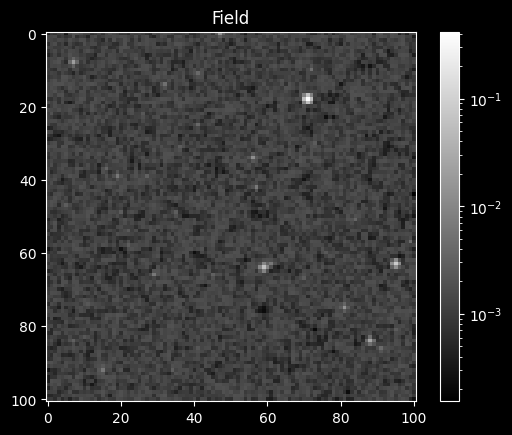

dark noise = 0.00029280446977859956


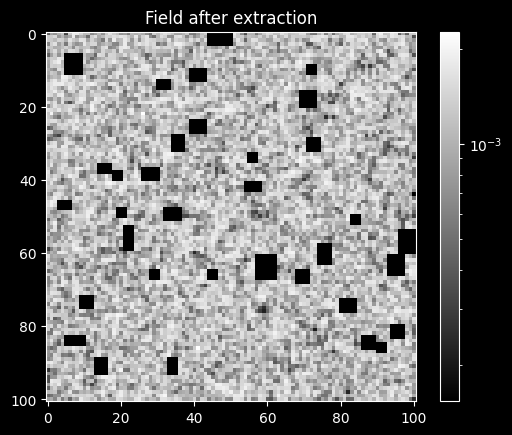


The number of extracted objs is: 35	70.00 % of the tot

====
Number of objects: 100


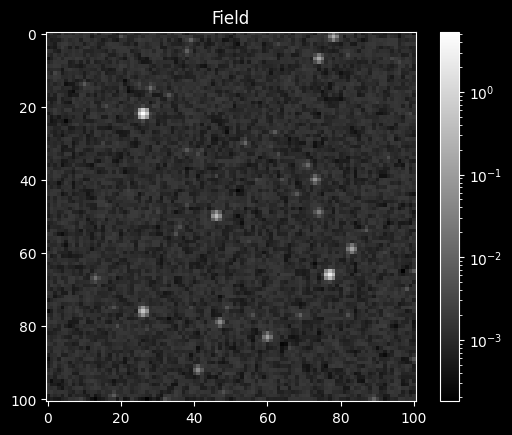

dark noise = 0.00028943996967626084


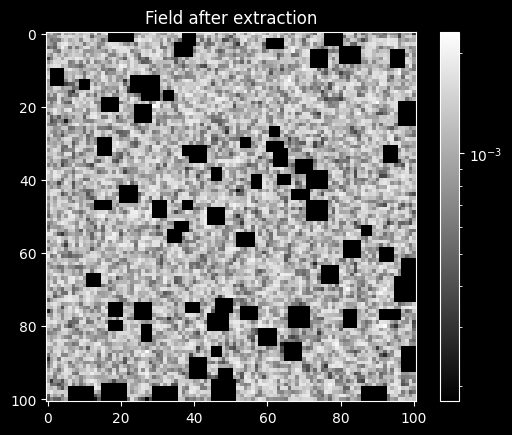


The number of extracted objs is: 68	68.00 % of the tot

====
Number of objects: 200


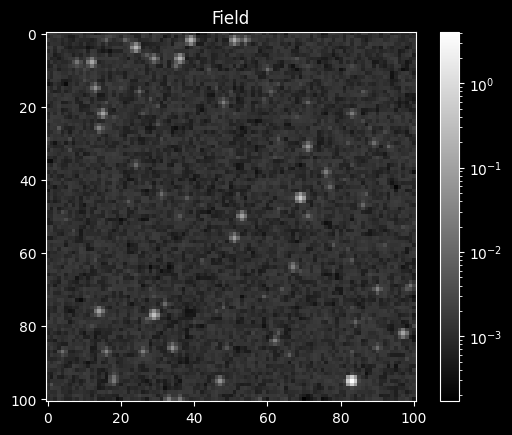

dark noise = 0.00028659136221333674


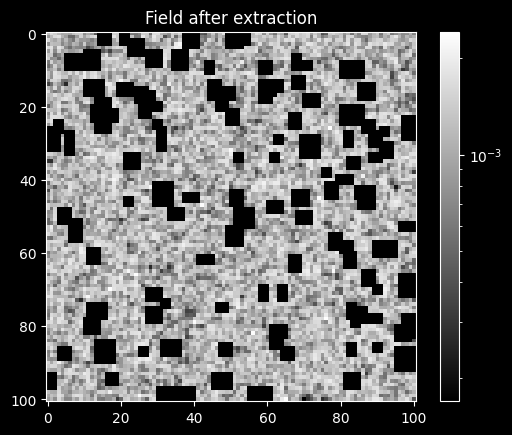


The number of extracted objs is: 117	58.50 % of the tot



In [50]:
# number of stars
n_stars = [50,100,200]
for stars in n_stars:
    print(f'====\nNumber of objects: {stars}')

    # generating the field and the stars
    F, S = initialize(sdim=stars)

    # setting background noise
    n = 0.2/1e2
    # detector noise
    det_noise = 3e-4

    # generating atmosferic seeing image with background and detector noise
    F_sn = atm_seeing(F + noise(n)) + noise(det_noise)

    plt.title('Field')
    plt.imshow(F_sn, norm='log',cmap='gray')
    plt.colorbar()
    plt.show()

    # making a copy of the field in order to preserve the original
    test_field = F_sn.copy()

    # mean dark
    dark = dark_elaboration(det_noise)
    # for the noise estimated from dark take the maximum
    d = dark[np.unravel_index(np.argmax(dark), dark.shape)]
    print(f'dark noise = {d}')

    # number of points
    p_num = 200 
    # thr to define an obj
    thr = 1e-2
    # detecting and extracting objects
    a_extraction = objects_detection(test_field, d, thr=thr, size=3, point_num=p_num)
    print(f'\nThe number of extracted objs is: {len(a_extraction)}\t{len(a_extraction)/stars*100:.2f} % of the tot\n')



Mean Luminosity of the sample
True	Recover
0.059	0.063
Lr/L = 106 %


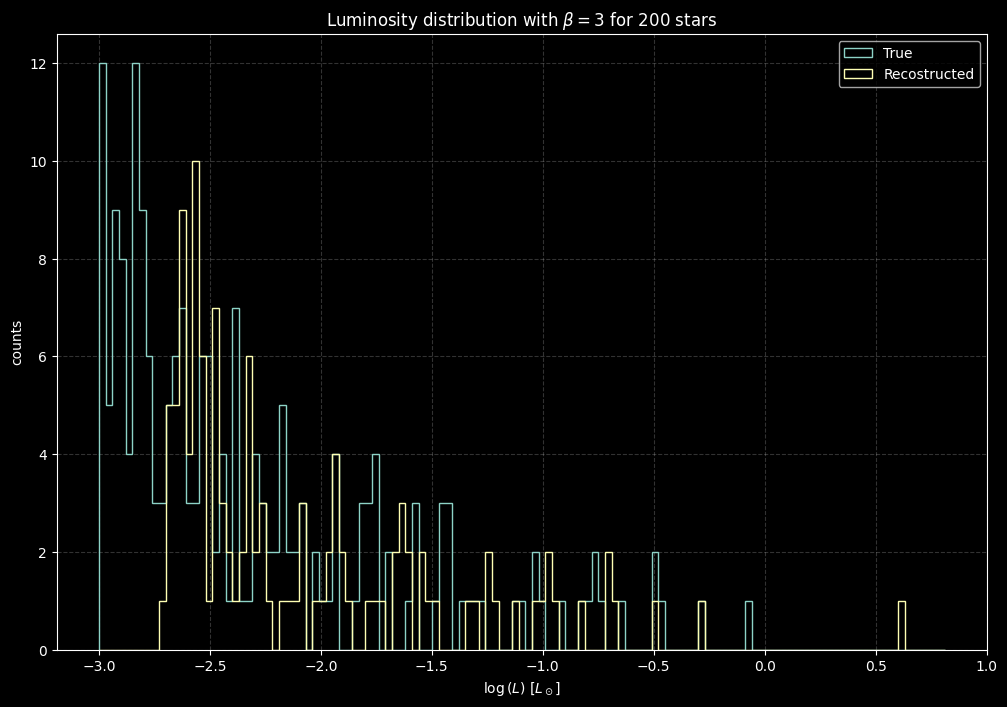

In [51]:
# collecting the maximum values of extracted objects in an array
L_r = np.array([])
for element in a_extraction:
    L_r = np.append(L_r, element[np.unravel_index(np.argmax(element), element.shape)])
# correcting the luminosities by mean dark noise
mean_dark = dark.sum()/(len(dark)**2)
L_r -= mean_dark
# computing the average
mean_Lr = L_r.sum()/len(L_r)

# defining the true luminosity sample
L = S.lum
# computing the average
mean_L = L.sum()/len(L)

print(f'Mean Luminosity of the sample\nTrue\tRecover\n{mean_L:.3f}\t{mean_Lr:.3f}\nLr/L = {mean_Lr/mean_L*100:.0f} %')

# Plot the comparison with the true sample
plt.figure(figsize=(12,8))
plt.title(f'Luminosity distribution with $\\beta = {beta}$ for {stars} stars')
bins = np.arange(min(np.log10(L).min(),np.log10(L_r).min()), max(np.log10(L).max(), np.log10(L_r).max()), 0.03)
# print(bins)
plt.hist(np.log10(L),bins=bins,histtype='step', label='True')
plt.hist(np.log10(L_r-d), bins=bins, histtype='step', label='Recostructed')
#plt.xticks(np.arange(-3.1,1.16,0.5))
plt.xlabel('$\log{(L)}$ [$L_\odot$]')
plt.ylabel('counts')
plt.legend()
plt.grid(linestyle='--', alpha=0.2)
plt.show()

## <a id='toc1_3_'></a>[III part: Image recover](#toc0_)

Assuming a $\delta$ function for the source and uniform distributed noises:

$$I (x,y) = \Pi (x,y) \ast (L_{\star}\cdot \delta (x-x_{\star},y-y_{\star}) + n_{bgr} (x,y)) + n_{det}(x,y) = $$
$$ = \Pi (x,y) \ast L_{\star}\cdot\delta(x-x_{\star},y-y_{\star}) + \Pi(x,y) \ast n_{bgr}(x,y) + n_{det}(x,y) = $$
$$ \equiv L_{\star}\cdot \Pi (x-x_{\star},y-y_{\star}) + n_{tot} (x,y)$$

where $I$ is the measured signal, $\Pi$ the _psf_, $L_{\star}$ the luminosity of the star, $n_{bgr}$ and $n_{det}$ are the noise of the background and the detector respectively.

If the system had been noiseless then:

$$I(x,y) = L_{\star}\cdot \Pi (x-x_{\star},y-y_{\star})$$

In this case knowing the functional form of the measured signal means knowing the psf

From Richardson-Lucy (R-L) algorithm:

$$I^{(r)}(x,y) = \int S^{(r)}(x',y') \Pi(x-x',y-y') dx'dy'$$

$$S^{(r+1)} (x,y) = \int S^{(r)} (x,y) \frac{I(x',y')}{I^{(r)}(x',y')} \Pi (x-x',y-y') dx'dxy' $$

$$S^{(0)}(x,y) = I(x,y)$$

In [90]:
from astropy.convolution import convolve

# cnt = 0
# for I in a_extraction:
#     element = np.copy(I)
#     element -= mean_dark
#     if len(np.where(element<0)[0]) != 0:
#         cnt += 1
# print(f'{cnt/len(a_extraction)*100} %')

# selecting an obj

def recover(I,r=3, P=[]):
    I = np.copy(I)
    if len(P) == 0:
        print(I.shape)
        xmax, ymax = np.unravel_index(np.argmax(I), I.shape)
        xl, xh = [0,None]
        yl, yh = [0,None]
        dim = I.shape[0]
        if dim == 1:
            xl, xh = 0,0
        elif (dim % 2) == 0:
            if xmax == 0:
                xl, xh = xmax, dim-1
            elif xmax == dim-1:
                xl, xh = 1, xmax+1
            else:
                if dim-1-xmax < xmax:
                    xl = 1
                else:
                    xh = -1
        dim = I.shape[1]
        if dim == 1:
            yl, yh = 0,0
        elif (dim % 2) == 0:
            if ymax == 0:
                yl, yh = ymax, dim-1 
            elif ymax == dim-1:
                yl, yh = 1, ymax+1
            else:
                if dim-1-ymax < ymax:
                    yl = 1
                else:
                    yh = dim-1
        print(xmax,ymax)
        print(xl,xh,yl,yh)
        P = I[xl:xh,yl:yh]

    if r==0:
        Ir = convolve(I,P)
        return I*convolve(I/Ir,P)
    else:
        Sr = recover(I,r-1,P)
        Ir = convolve(Sr,P)
        return Sr*convolve(I/Ir,P)

ind = 20
print(f'number of stars: {len(L)}')
print(f'number of found stars: {len(a_extraction)}')

# fig, [ax1, ax2] = plt.subplots(2,1)
#field_image(fig,ax1,I)

for ind in range(min(len(L),len(a_extraction))): 
    try:
        I = a_extraction[ind]
        it = 10
        I_r = recover(I,it)


        print(f'Lum:\nbefore recover\nI =\t{I[np.unravel_index(np.argmax(I),I.shape)]}')

        print(f'after recover:\nS =\t{I_r[np.unravel_index(np.argmax(I_r),I_r.shape)]}')

        #field_image(fig,ax2,I_r)

        tmpL = np.sort(L)[::-1]
        print(f'true value:\nL =\t{tmpL[ind]}')

        print(f'accuracy ratio:\t Ir/L = {I_r[np.unravel_index(np.argmax(I_r),I_r.shape)]/tmpL[ind]*100:.2f} %')
    except:
        print(f'Index value: {ind}')
        raise
# plt.show()


number of stars: 200
number of found stars: 117
(5, 5)
2 2
0 None 0 None
Lum:
before recover
I =	4.090850823627918
after recover:
S =	6.382771522605974
true value:
L =	6.610502232356777
accuracy ratio:	 Ir/L = 96.56 %
(5, 5)
2 2
0 None 0 None
Lum:
before recover
I =	0.5103976680240211
after recover:
S =	0.8086640635761576
true value:
L =	0.8223929223768602
accuracy ratio:	 Ir/L = 98.33 %
(5, 5)
2 2
0 None 0 None
Lum:
before recover
I =	0.33074820598254434
after recover:
S =	0.5371763270423396
true value:
L =	0.5328329822676843
accuracy ratio:	 Ir/L = 100.82 %
(5, 5)
2 2
0 None 0 None
Lum:
before recover
I =	0.21760144676453075
after recover:
S =	0.36068945492732235
true value:
L =	0.34977012200289137
accuracy ratio:	 Ir/L = 103.12 %
(5, 5)
2 2
0 None 0 None
Lum:
before recover
I =	0.19808015621273595
after recover:
S =	0.3239308350458664
true value:
L =	0.31895525310650447
accuracy ratio:	 Ir/L = 101.56 %
(6, 5)
2 2
0 -1 0 None
Lum:
before recover
I =	0.19591522525646934
after recover:

/tmp/ipykernel_16509/69363956.py:52: RuntimeWarning: invalid value encountered in divide
  return I*convolve(I/Ir,P)
/tmp/ipykernel_16509/69363956.py:56: RuntimeWarning: invalid value encountered in divide
  return Sr*convolve(I/Ir,P)


ValueError: The kernel can't be normalized, because its sum is close to zero. The sum of the given kernel is < 0.01